This notebook generated table-formatted features from the given JSON file.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import requests
import time
import json
import datetime
from tqdm import tqdm
from pandas.io.json import json_normalize
strptime = datetime.datetime.strptime
plt.rcParams['figure.figsize'] = (16, 4)

In [2]:
with open('Surroundings.json') as f:
    js = json.load(f)

In [3]:
len(js)

546

JSON data contains information for each `store_code` in the following format:

```
[... list of]
    {
        store_code: Int,
        surroundings: [... list of]
            {
                String: [... list of]
                    {
                        address_components: [... list of]
                            {
                                long_name: String,
                                short_name: String,
                                types: [... list of String]
                            },
                        formatted_address: String,
                        icon: String,
                        international_phone_number: String,
                        latitude: Float,
                        longitude: Float,
                        name: String,
                        opening_hours:
                        {
                            open_now: Boolean,
                            periods: [... list of]
                               {
                                   [open, close]:
                                       {
                                           day: Int,
                                           time: String
                                        }
                               }
                            weekday_text: [... list of String]
                        }
                        place_id: String,
                        rating: Float,
                        reviews: [... list of]
                            {
                               author_name: String,
                               author_url: String,
                               language: String,
                               profile_photo_url: String,
                               rating: Int,
                               relative_time_description: String,
                               text: String,
                               time: Int
                            }
                        types: [... list of String],
                        user_ratings_total: Int
                    }
            }
    }
```

Only certain fields are of relevance for our scenario of predicting store sales volume. We will need to extract necessary information into a matrix format.

First, restructure the JSON into a slightly different structure where entries are stored as dictionary values instead of a list

In [21]:
JS = {}
for j in js:
    JS[j['store_code']] = j['surroundings']

# Number of amenities

This data tells us how many amenities of each type the store has in its surroundings.

In [22]:
am = {i: {k: len(v) for k, v in j.items()} for i, j in JS.items()}

In [23]:
am_df = pd.DataFrame(am).T

Most amenity types are not present for most stores:

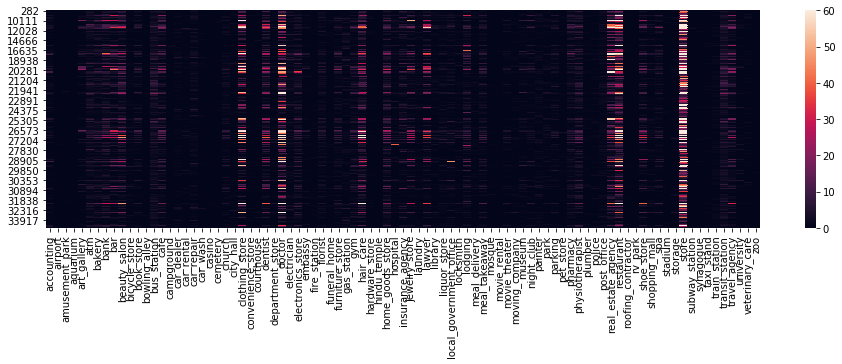

In [37]:
sns.heatmap(am_df, xticklabels=am_df.columns)

# Location of amenities

This data tells us average latitude and logitude of amenities of each kind. Since the location of store itself is unknown, it 's impossible to calculate e.g. distance to closest amenity.

Potential work:
- calculate mean latitude and logitude of all nearby amenities and use that as proxy for the geolocation of the store
- extract min, max and std of latitudes and longitudes, in addition to the mean
- do 2D graph analysis of the locations

In [73]:
geo = {
    i: {
        '{}_{}'.format(k, a): np.mean([i[a] for i in v]) for k, v in j.items() for a in ['latitude', 'longitude']
    } 
    for i, j in JS.items()
}

c:\miniconda2\envs\python3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\miniconda2\envs\python3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [75]:
geo = pd.DataFrame(geo).T

In [80]:
geo.head()

,accounting_latitude,accounting_longitude,airport_latitude,airport_longitude,amusement_park_latitude,amusement_park_longitude,aquarium_latitude,aquarium_longitude,art_gallery_latitude,art_gallery_longitude,...,transit_station_latitude,transit_station_longitude,travel_agency_latitude,travel_agency_longitude,university_latitude,university_longitude,veterinary_care_latitude,veterinary_care_longitude,zoo_latitude,zoo_longitude
282,47.697580,8.634551,NaN,NaN,NaN,NaN,NaN,NaN,47.696621,8.635800,...,47.698110,8.632954,47.697361,8.634665,NaN,NaN,NaN,NaN,NaN,NaN
425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.617244,7.055741,46.618805,7.056704,NaN,NaN,NaN,NaN,NaN,NaN
2286,46.517331,6.629884,NaN,NaN,NaN,NaN,NaN,NaN,46.515448,6.629263,...,46.516159,6.629901,46.515894,6.629854,46.51753,6.630587,46.515315,6.631812,NaN,NaN
2331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.104761,7.074551,...,46.104833,7.077669,46.105665,7.078785,NaN,NaN,NaN,NaN,NaN,NaN


# Opening times

Opening times is the most challenging part to parse and there different kinds of metadata we can extract from them. Here, we extract the total time open during each day of the week.

Potential work:
- get opening times during different parts of day (morning, day, evening, night, lunch, dinner etc)
- get information of being open during a each hour of the day
- get opening and closing times on certain days (e.g. weekends, holidays)
- get open activity during different week and months
- get raw opening and closing times (aggregation of different days may be needed)

In [117]:
ix = [i['store_code'] for i in js]

In [106]:
js2 = []
for j in tqdm(js):
    j2 = {}
    for name, amenities in j['surroundings'].items():
        # no amenities in current category = continue
        if not len(amenities):
            continue
            
        durations = []        
        for wd in amenities:
            times = []
            periods = wd.get('opening_hours', {}).get('periods')
            # some amenities don't have open times information = continue
            if periods is None:
                continue

            # iterate over opening hours periods to construct dataframe of
            # alternating open and close times
            for period in periods:
                for k, v in period.items():
                    times.append(
                        (k, strptime(v['time'], '%H%M').replace(day=v['day'] + 1), v['day'])
                    )
            times = sorted(times, key=lambda x: x[1])
            d = pd.DataFrame(times)
            
            # calculate differences between open and close times
            # each entry should say how long a place is open after being opened
            # on a given day
            d['diff'] = pd.concat([d[1], d[1] + pd.Timedelta(days=7)]).diff().iloc[len(d):]
            d['day'] = np.roll(d[2], 1)
            di = d[d[0] == 'close'].set_index('day')['diff']
                        
            # if there are no entries, it means that the place never closed
            # i.e. openinig hours are 24 hours every day
            if not len(di):
                duration = {a: 24 for a in range(7)}
            else:
                duration = di.dt.components.hours.to_dict()

            durations.append(duration)
            
        j2[name] = durations
    js2.append(j2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 546/546 [04:32<00:00,  2.01it/s]


In [111]:
with open('js2.json', 'w') as f:
    json.dump(js2, f)

Now we need to decide on how to aggregate opening times across multiple amenities. Here we take the average of the total time open across all amenities of each type.

Potential work:
- also extract std, min and max of total time open
- don't aggregate and instead set each amenity as a separate feature. In this case, ordering of amenities will need to be decided and different number of amenities for different stores needs to be handled.

In [114]:
js3 = 
for j2 in tqdm(js2):
    j3 = {}
    for k, v in j2.items():
        d = pd.DataFrame(v).mean(0)
        d.index = d.index.map(lambda x: '{}_{}'.format(k, x))
        j3.update(d.to_dict())
    js3.append(j3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 546/546 [00:16<00:00, 32.27it/s]


In [120]:
df_opened = json_normalize(js3)
df_opened.index = ix

In [188]:
df_opened = df_opened.loc[~df_opened.index.duplicated()]

In [133]:
df_opened.head()

,accounting_0,accounting_1,accounting_2,accounting_3,accounting_4,accounting_5,accounting_6,airport_0,airport_1,airport_2,...,veterinary_care_4,veterinary_care_5,veterinary_care_6,zoo_0,zoo_1,zoo_2,zoo_3,zoo_4,zoo_5,zoo_6
10055,NaN,8.0,8.0,8.0,8.0,8.0,NaN,NaN,NaN,NaN,...,11.0,11.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10079,NaN,3.0,3.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see that many columns are predominantly null, i.e. many amenities are not open on a particular day for most stores:

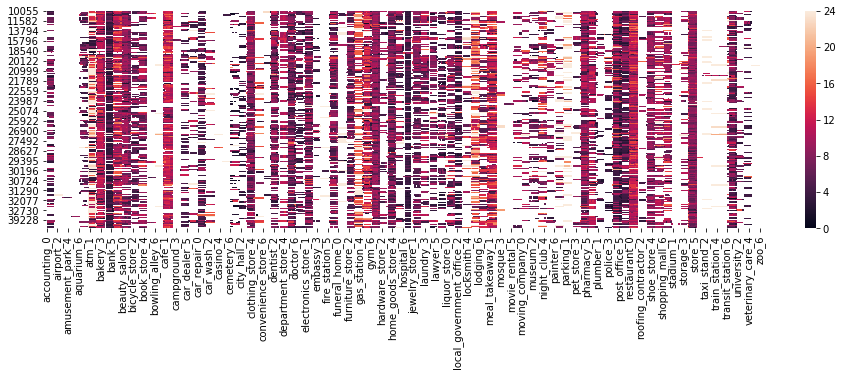

In [134]:
sns.heatmap(df_opened)

# Rating

We can also extract ratings for surrounding amenities. Similarly to the other features, we take the average of the rating across different amenities within each type.

In [145]:
rating = {
    i: {
        k: np.mean([i.get('rating', np.nan) for i in v]) for k, v in j.items()
    } 
    for i, j in JS.items()
}

c:\miniconda2\envs\python3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\miniconda2\envs\python3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [149]:
rating = pd.DataFrame(rating).T

In [150]:
rating.head()

,accounting,airport,amusement_park,aquarium,art_gallery,atm,bakery,bank,bar,beauty_salon,...,store,subway_station,synagogue,taxi_stand,train_station,transit_station,travel_agency,university,veterinary_care,zoo
282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1498,NaN,NaN,NaN,NaN,NaN,NaN,4.05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN
2286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.166667,NaN,...,NaN,4.15,NaN,NaN,4.1,NaN,NaN,NaN,4.8,NaN
2331,NaN,NaN,NaN,NaN,NaN,NaN,3.80,3.9,NaN,NaN,...,NaN,NaN,NaN,NaN,3.9,NaN,5.0,NaN,NaN,NaN


Many amenity types lack ratings, either because there are no amenities present or there are no ratings.

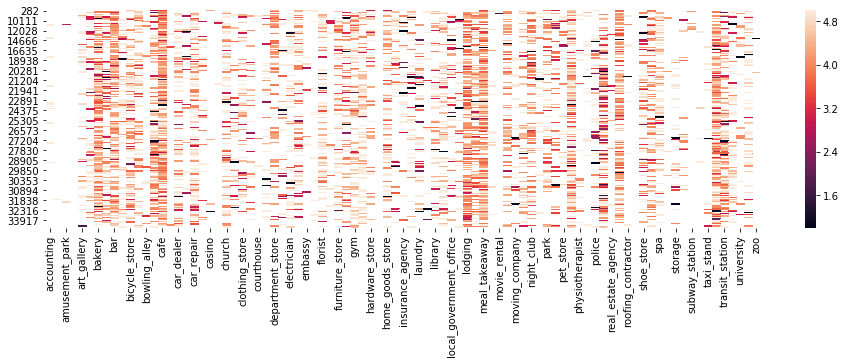

In [151]:
sns.heatmap(rating)

Looking at the amenity types that do have ratings for more than 20% of store entries, post offices are rated the lowest.

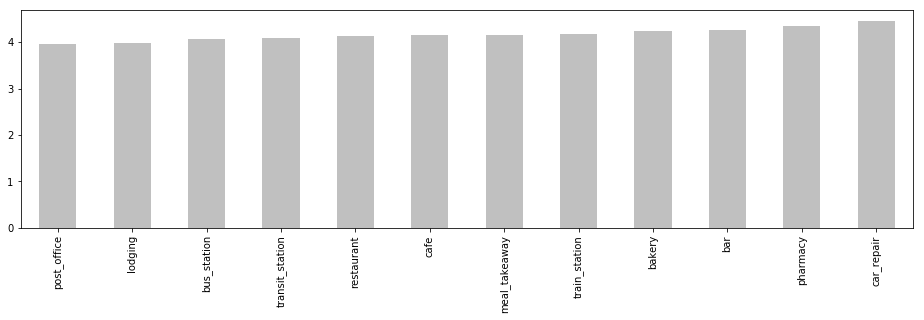

In [175]:
rating.loc[:, (rating.notnull().sum() / len(rating)) > 0.2].mean(0).sort_values().plot.bar(color='silver')

In [194]:
rating.columns = ['{}_rating'.format(i) for i in rating.columns]

We will use the resulted data sets in the next steps of model training.

In [195]:
am_df.shape, geo.shape, df_opened.shape, rating.shape

((545, 89), (545, 178), (545, 595), (545, 89))

In [199]:
am_df.to_csv('df_n.csv')
geo.to_csv('df_geo.csv')
df_opened.to_csv('df_opened.csv')
rating.to_csv('df_rating.csv')

# Potential work

We could potentially try to employ other fields of the JSON file

- NLP on the text of reviews
- NLP on text geographical data, such as street and city names
- process individual review to get a better measure of rating (e.g. taking into account time of reviews and spread of ratings)
- as mentioned above, include more information than taking averages of latitude, longitudes, opening times etc.

We could also do feature engineering across different fields, e.g.

- use location of the amenity when calculating total rating
- use location of the amenity when calculating opening hours duration
- group different amenity types (e.g. `shoe_store` and `clothing_store`) and do feature engineering for entire group